# Groover x Sylvain

In [1]:
import pandas as pd
import os

%matplotlib inline

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'Groover%20Data%20Challenge.pdf',
 'groover_dataset_challenge.csv',
 'groover_sylvain.ipynb']

In [3]:
df = pd.read_csv('groover_dataset_challenge.csv')

Let's explore the data to get an insight.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70346 entries, 0 to 70345
Data columns (total 10 columns):
id                  70346 non-null int64
track__id           70346 non-null int64
band_id             70346 non-null int64
influencer_kind     70346 non-null object
influencer_id       70346 non-null int64
decision            70346 non-null object
feedback            70344 non-null object
score               70346 non-null float64
date_created        70346 non-null object
acceptation_rate    69832 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 5.4+ MB


It seems that the target variable is score. I am wondering if score is computed based on decision and maybe on a sentiment analysis on feedback...
Influencer_kind  should be used to compute the match between band/track and influencer but no data is available for band/track, except influencer's evaluation.
Also, we see there is missing values for acceptation_rate.

In [5]:
df.head()

,id,track__id,band_id,influencer_kind,influencer_id,decision,feedback,score,date_created,acceptation_rate
0,7312,324,303,Label,102,['give feedback on your tune'],"Bonjour, \nle track surf sur les codes ""austra...",0.0,2018-05-01 16:14:59.062779+00:00,0.072917
1,7313,324,303,Radio,103,['give feedback on your tune'],"Bonjour, merci pour votre envoi. Le morceau n'...",0.0,2018-05-01 16:14:59.065279+00:00,0.111732
2,7314,324,303,Journalist,104,['give feedback on your tune'],Le morceau est à lui tout seul une succession ...,0.0,2018-05-01 16:14:59.067538+00:00,0.000000
3,7315,324,303,Channel,105,"['share it on social media', 'add it to a play...",Très bonne pop aux airs de Tame Impala et Pond...,1.0,2018-05-01 16:14:59.069965+00:00,0.400000
4,7316,324,303,Media,106,['give feedback on your tune'],"La production est assurément excellente, mais ...",0.0,2018-05-01 16:14:59.072229+00:00,NaN


In [6]:
df.describe()

,id,track__id,band_id,influencer_id,score,acceptation_rate
count,70346.000000,70346.000000,70346.000000,70346.000000,70346.000000,69832.000000
mean,134527.993319,5395.774244,3634.004521,428.395317,0.255224,0.251735
std,75929.591832,2839.092464,2213.433424,225.814764,0.399576,0.259732
min,7312.000000,324.000000,303.000000,97.000000,0.000000,0.000000
25%,69498.250000,3088.000000,1728.000000,262.000000,0.000000,0.059160
50%,137248.500000,5292.000000,3415.000000,394.000000,0.000000,0.160714
75%,190546.750000,7540.000000,5336.000000,569.000000,0.250000,0.331967
max,278326.000000,11736.000000,8737.000000,1166.000000,1.000000,1.000000


What are the distinct decisions available? We will answer this question in the following code.

In [7]:
import ast
from pprint import pprint

s = set()
for i, x in df.iterrows():
    l = ast.literal_eval(x["decision"])
    for i in l:
        s.add(i)
pprint(s)

{'add it to a Spotify playlist',
 'add it to a playlist',
 'allows you to give a reply to this feedback',
 'broadcast your tune',
 'get in touch with the artist for a gig',
 'get in touch with you and/or know more about your project',
 'give feedback on your tune',
 'invite or interview you',
 'share it on his Youtube channel',
 'share it on his channel',
 'share it on social media',
 'share it to his/her team',
 'write a wise advice',
 'write an article'}


Next, we compute missing values for acceptation_rate feature.

In [8]:
import numpy as np
df['accepted'] = df.score.apply(lambda x: 1.0 if x>0.25 else 0.0)
df_fillna = df[['influencer_id', 'accepted']].groupby("influencer_id").mean()

# Je vérifie que je remplis bien avec les bonnes valeurs
from sklearn.metrics import mean_squared_error
y_check = df[['influencer_id', 'acceptation_rate']].dropna().acceptation_rate
y_nan = df[['influencer_id', 'acceptation_rate']].dropna().influencer_id.apply(lambda x:df_fillna.loc[x,'accepted'] )
print("check MSE:",mean_squared_error(y_nan, y_check)/df.score.std())

# et je remplis les valeurs manquantes
def fill_acc_rate(inf_id, value):
    if np.isnan(value):
        return df_fillna.loc[inf_id,'accepted']
    else:
        return value
df["acceptation_rate"] = np.vectorize(fill_acc_rate)(df.influencer_id, df.acceptation_rate)
df.drop(columns=['accepted'], inplace=True)

check MSE: 0.009730576483668433


The computation I have done for acceptation_rate is not stricly equal to predefined values in the dataset, but based on MSE, it looks really close. Maybe I should have a look at date_created.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70346 entries, 0 to 70345
Data columns (total 10 columns):
id                  70346 non-null int64
track__id           70346 non-null int64
band_id             70346 non-null int64
influencer_kind     70346 non-null object
influencer_id       70346 non-null int64
decision            70346 non-null object
feedback            70344 non-null object
score               70346 non-null float64
date_created        70346 non-null object
acceptation_rate    70346 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 5.4+ MB


I check that there is no more missing values. And this is the case.

To improve prediction, I remove influencers with few evaluations. We could do the same thing with band. But I commented the code due to over elimination.

In [10]:
#clean up influencer with few ratings
df_influencer_grouped = df.groupby("influencer_id")['id'].count().reset_index()
keep_influencer = df_influencer_grouped.loc[df_influencer_grouped.id>50].influencer_id.tolist()
df = df.loc[df.influencer_id.isin(keep_influencer)]
# clean up band with few ratings
# df_band_grouped = df.groupby("band_id")['id'].count().reset_index()
# keep_band = df_band_grouped.loc[df_band_grouped.id>20].band_id.tolist()
# df = df.loc[df.band_id.isin(keep_band)]


# Exercise 1

## a/ Prediction of missing values

To fullfill this objective, we will use collaborative filtering. It would be difficult to do recommendation based on content because no data is available for band/track.
We agglomerate by using, for each band, the max score of all their tracks. I use max agglomeration because it is relevant to say that a band matches if at least one track has a good score with the influencer.
Then, we do a train/test split to evaluate the model later.


In [11]:
from sklearn.model_selection import train_test_split
df_grouped_by_band = df.groupby(['influencer_id','band_id'])['score'].max().reset_index()
# train / test split
train, test = train_test_split(df_grouped_by_band, test_size=0.2, random_state=42)
ratings_ref = df_grouped_by_band.pivot_table(index='influencer_id',columns='band_id',values='score').fillna(0)
ratings_train =train.pivot_table(index='influencer_id',columns='band_id',values='score').fillna(0)
# in case of track analysis, uncomment the line below
#ratings= train.pivot_table(index='influencer_id',columns='track__id',values='score').fillna(0)
print("Sparsity:{:4.2f}%".format(100*train.shape[0]/float(ratings_train.shape[0]*ratings_train.shape[1])))

Sparsity:4.61%


We store indexes to be able to map influencer_id and band_id in the matrix values.

In [12]:
# get indexes
ipos={v:i for i,v in enumerate(ratings_train.index.values)}
bpos={v:i for i,v in enumerate(ratings_train.columns)}

The method used for Collaborative Filtering is to rebuild the matrix by means of Singular Value Decomposition.

In [13]:
from scipy.sparse.linalg import svds
U,S,V=svds((ratings_train-ratings_train.mean()),k=200)
newM=(U.dot(np.diag(S))).dot(V)+ratings_train.mean().values

#from sklearn.decomposition import NMF
#model = NMF(n_components=200, init='random', random_state=0)
#W = model.fit_transform(ratings)
#H = model.components_
#newM = np.dot(W, H)

As requested, we do a prediction for band 6593.

In [14]:
predictions=[]
band_index = bpos[6593]
ind = np.argsort(newM[:,band_index])[-10:]
print("PREDICTIONS")
for i in ind:
    print(ratings_train.index[i],newM[i,band_index], ratings_train.values[i,band_index])
ind2 = np.argsort(ratings_train.values[:,band_index])[-10:]
print("---")
print("REFERENCE")
for i in ind2:
    print(ratings_train.index[i],newM[i,band_index], ratings_train.values[i,band_index])


PREDICTIONS
621 0.02907932856468281 0.0
351 0.03057138687941753 0.0
326 0.030827067258888213 0.0
628 0.04418856695497002 0.0
537 0.24999708224387396 0.25
117 0.25159188081995987 0.25
1073 0.9708701725489933 1.0
130 0.9985993164015704 1.0
127 1.0003120885046553 1.0
295 1.0016069326664987 1.0
---
REFERENCE
348 -0.03671626024634053 0.0
344 0.00012786997580195927 0.0
352 -0.0010241893071670088 0.0
107 -0.013287685206640028 0.0
117 0.25159188081995987 0.25
537 0.24999708224387396 0.25
295 1.0016069326664987 1.0
130 0.9985993164015704 1.0
127 1.0003120885046553 1.0
1073 0.9708701725489933 1.0


As we can see, predictions are really close to reference. 

Let's have a closer look at original data.

In [15]:
df.query('band_id==6593')[['band_id','track__id','influencer_id','score']]

,band_id,track__id,influencer_id,score
53914,6593,7982,127,0.00
53915,6593,7982,117,0.25
53916,6593,7982,389,0.00
57292,6593,8629,127,1.00
63767,6593,9887,117,0.25
63768,6593,9887,910,0.00
63769,6593,9887,520,0.00
63771,6593,9887,133,0.00
63772,6593,9887,111,1.00
63773,6593,9887,295,1.00


This difference is due to agglomeration per band. 

## b/ Measure the quality of recommandations

To assess the quality of our recommendations, we use the well-known cross validation technique.


In [16]:
mse = 0.0
count = 0
std = 0
mean = 0
for i, row in test.iterrows():
    if row['influencer_id'] not in ipos or row['band_id'] not in bpos:
        continue
    ii=ipos[row['influencer_id']]
    bi=bpos[row['band_id']]
    mse += (newM[ii,bi]-ratings_ref.values[ii,bi])**2
    count +=1
    mean +=ratings_ref.values[ii,bi]
mean/=count
for i, row in test.iterrows():
    if row['influencer_id'] not in ipos or row['band_id'] not in bpos:
        continue
    std += (ratings_ref.values[ii,bi]-mean)**2
    
print("RMSE:", np.sqrt(mse/count), 'STD ref', np.sqrt(std/count)," R2 :", 1.0-mse/std)

RMSE: 0.18908560213210399 STD ref 0.9606281893366195  R2 : 0.9612558383252335


Our model seems really good.
Finaly, let's train our model on the whole dataset to improve future predictions.

In [17]:
ratings =df.groupby(['influencer_id','band_id'])['score'].max().reset_index().pivot_table(index='influencer_id',columns='band_id',values='score').fillna(0)
ipos={v:i for i,v in enumerate(ratings.index.values)}
bpos={v:i for i,v in enumerate(ratings.columns)}
U,S,V=svds((ratings-ratings.mean()),k=200)
newM=(U.dot(np.diag(S))).dot(V)+ratings.mean().values


# Exercise 2

First, we compute a similarity matrix from score. The basic idea is that bands evaluated in the same way should be similar.


In [18]:
from sklearn.metrics.pairwise import cosine_similarity
def similarity(data_matrix, kind='influencer_id'):
    if kind == 'influencer_id':
        return cosine_similarity(data_matrix)
    elif kind == 'band_id':
        return cosine_similarity(data_matrix.T)

In [19]:
band_similarity = similarity(newM, kind='band_id')

Next, we find the top 10 bands similar to band 6593.

In [20]:
def top_k_band(ratings, similarity, mapper, band_id, k=10):
    return [ratings.columns[x] for x in np.argsort(similarity[mapper[band_id],:])[:-k-2:-1]][1:]

top_k_band(ratings,band_similarity, bpos, 6593)

[4830, 4120, 6862, 5585, 3528, 446, 1948, 8228, 1393, 7039]

# Exercise 3

Sparsity gives us the % of missing values. It is not that small. So we can expect a good accuracy by CF.

In [21]:
ratings_stats =df.groupby(['influencer_id','band_id'])['score'].mean().reset_index().pivot_table(index='influencer_id',columns='band_id',values='score').fillna(0)
# in case of track, uncomment the line below
#ratings= train.pivot_table(index='influencer_id',columns='track__id',values='score').fillna(0)
print("Sparsity:{:4.2f}%".format(100*df.shape[0]/float(ratings_stats.shape[0]*ratings_stats.shape[1])))

Sparsity:6.37%


Few bands have published more than 20 tracks. It may be difficult to evaluate bands with few tracks.

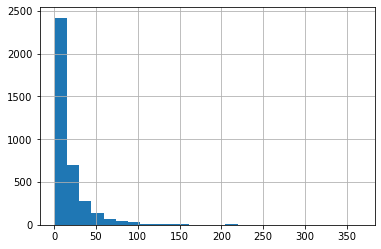

In [22]:
df.groupby("band_id").id.count().hist(bins=25)

We have a lot of influencers with more than 100 evaluations. Considering that, it should be possible to evaluate properly their preferences in terms of band/track.

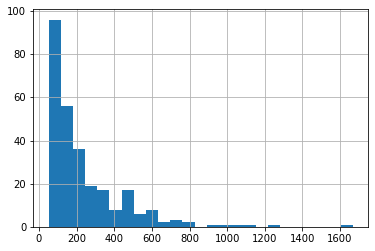

In [23]:
df.groupby("influencer_id").id.count().hist(bins=25)

The figure below illustrates that a lot of scores are null. It means that influencers are really selective on tracks.


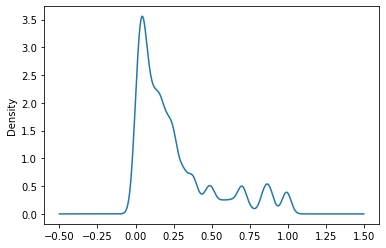

In [24]:
df.acceptation_rate.plot(kind='kde')

# Exercice 4

Considering the data available on each band, we can look for similar bands in the dataset related to influencers used earlier. Then we can predict the top influencer for each band.
I propose to use KNN approach. By that, I mean to build a similarity vector for a cold start band with bands in our previous dataset, considering subgenres and social networks data. Then for the top K bands closer to the cold start band, we seek for the best H influencers. Finaly, we select the most frequent influencers among the H influencers for the K bands. Or, another approach, we compute a new score for each influencer such as similarity band x influencer/band score. And we select the top influencers with this new score.


## References

https://medium.com/datadriveninvestor/how-to-built-a-recommender-system-rs-616c988d64b2

https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/
